# Installation

In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -q -i 0 | grep "Product Name"
#https://drive.google.com/drive/folders/1_kHJFZ_31Pa4fOPeovChvuLt-xj-B6h-?usp=sharing
%cd /content/drive/MyDrive/MaskRCNN_wandb

    Product Name                          : Tesla P100-PCIE-16GB
/content/drive/MyDrive/MaskRCNN_wandb


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install keras==2.1.6

In [ ]:
%tensorflow_version 1.x 
import tensorflow as tf
print("tf", tf.__version__) #1.5.2 -> 1.15.0
import keras
print("keras", keras.__version__) #2.2.5 -> 2.1.6 req
import numpy as np
print("np", np.__version__) #1.20.0
import scipy
print("scipy", scipy.__version__) #1.2.2

TensorFlow 1.x selected.
tf 1.15.2
keras 2.1.6
np 1.20.0
scipy 1.2.2


Using TensorFlow backend.


In [ ]:
!wandb init

# Configuration

In [ ]:
%cd /content/drive/MyDrive/MaskRCNN_wandb

/content/drive/MyDrive/MaskRCNN_wandb


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://drive.google.com/drive/folders/10K7c6lej1KbZ5zIIAWI-k15fm9TcdRji?usp=sharing
DATASET_PATH = '/content/drive/MyDrive/Isuzu first run'

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.model import load_image_gt
import matplotlib.pyplot as plt
# Root directory of the project
# ROOT_DIR = os.path.abspath("/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/")
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN_wandb")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "IsuzuFR"
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # Background + (5 Car model)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 100
    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_MAX_INSTANCES = 1

    IMAGE_MAX_DIM=512
    IMAGE_MIN_DIM=512
    
    BACKBONE = "resnet101"

    RPN_ANCHOR_SCALES  = [16, 32, 64, 128, 256]
    # MODEL TUNING
    if os.environ.get('BACKBONE'):
        BACKBONE = os.environ.get('BACKBONE')
    if os.environ.get('GRADIENT_CLIP_NORM'):
        GRADIENT_CLIP_NORM = float(os.environ.get('GRADIENT_CLIP_NORM'))
    if os.environ.get('LEARNING_RATE'):
        LEARNING_RATE = float(os.environ.get('LEARNING_RATE'))
    if os.environ.get('WEIGHT_DECAY'):
        WEIGHT_DECAY = float(os.environ.get('WEIGHT_DECAY'))
    def get_config_dict(self):
        """Return Configuration values as a dictionary for the sake of syncing with wandb"""
        d = {}
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                d[a] = getattr(self, a)
        return d

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "DMAX 1 ตอน")
        self.add_class("object", 2, "DMAX 1 ตอนครึ่ง")
        self.add_class("object", 3, "DMAX 2 ตอน")
        self.add_class("object", 4, "MU7")
        self.add_class("object", 5, "MUX")


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"DMAX 1 ตอน": 1,"DMAX 1 ตอนครึ่ง": 2, "DMAX 2 ตอน":3, "MU7":4, "MUX":5} 
                         
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  512
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           IsuzuFR
NUM_CLASSES                    6
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_N

In [ ]:
## Define some global constants

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN_wandb")
# Path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
if os.path.exists(DEFAULT_LOGS_DIR)==False:
    os.mkdir(DEFAULT_LOGS_DIR)
    
## Download pretrained COCO Model!
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom(DATASET_PATH, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(DATASET_PATH, "val")
dataset_val.prepare()

objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 1 ตอน']
objects: ['DMAX 

In [ ]:
import wandb
import matplotlib.pyplot as plt
import keras
import scipy
run = wandb.init(project="toyota_first_run", resume=True)
_config = CustomConfig()

config_dict = _config.get_config_dict()
configs_of_interest = ['BACKBONE', 'GRADIENT_CLIP_NORM', 'LEARNING_MOMENTUM', 'LEARNING_RATE',
                        'WEIGHT_DECAY', 'STEPS_PER_EPOCH']

wandb.log({k: config_dict[k] for k in configs_of_interest})


def fig_to_array(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    buf = np.roll(buf, 3, axis=2)
    return buf

class ImageCallback(keras.callbacks.Callback):
    def __init__(self, run, dataset_val, dataset_train,infer_config,log_dir):
        super(ImageCallback, self).__init__()
        self.run = run
        self.dataset_val = dataset_val
        self.dataset_train = dataset_train
        self.image_ids = [103,47,8,48] #or dataset_val.image_ids[:3]
        self.infer_config = infer_config
        self.log_dir=log_dir
        self.inf_model = modellib.MaskRCNN(mode="inference", config=self.infer_config ,
                                  model_dir=log_dir,callbacks=[])
        
    def load_curr_model(self):
        model_path = self.inf_model.find_last()[1]
        self.inf_model.load_weights(model_path, by_name=True)

    def predict_image(self, image_id):
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(
            self.dataset_val, _config, image_id, use_mini_mask=False)
        _, ax = plt.subplots(figsize=(16, 16)) 
        
        # Run detection
        results = self.inf_model.detect([original_image])

        # Visualize results
        r = results[0]
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                self.dataset_val.class_names, r['scores'],figsize=(16,16), 
            ax=ax)
        return fig_to_array(ax.figure)

    def on_epoch_end(self, epoch, logs):
        print("Uploading images to wandb...")
        self.load_curr_model();
        predicted_images = [self.predict_image(i) for i in self.image_ids]
        wandb.log({"img_segmentations":[
            wandb.Image(
                scipy.misc.imresize(img, 50),
                caption="SampleImage",
                mode='RGBA') for img in predicted_images]})
        print('Images uploaded to wandb.')

class PerformanceCallback(keras.callbacks.Callback):
    def __init__(self, run):
        self.run = run
    def on_epoch_end(self, epoch, logs):
        print("Uploading metrics to wandb...")
        #self.run.history.row.update(logs)
        wandb.log(logs)
        #self.run.history.add()
        print('Metrics uploaded to wandb.')

wandb: Currently logged in as: crb. Use `wandb login --relogin` to force relogin


In [ ]:
class InferenceConfig(CustomConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.1
    
inf_config = InferenceConfig()
# callbacks = [
#     ImageCallback(
#     run,
#     dataset_val,
#     dataset_train,inf_config,DEFAULT_LOGS_DIR),
#     PerformanceCallback(run)]
callbacks = [PerformanceCallback(run)]

In [ ]:
weights_path = COCO_MODEL_PATH #train from coco

In [ ]:
DEVICE = "/gpu:0" 
with tf.device(DEVICE):
  # model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)
  model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR, callbacks=callbacks)
  # Load weights
  print("Loading weights ", weights_path)
  model.load_weights(weights_path, by_name=True, exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Loading weights  /content/drive/MyDrive/MaskRCNN_wandb/mask_rcnn_coco.h5








In [ ]:
dataset_train.class_names

['BG', 'DMAX 1 ตอน', 'DMAX 1 ตอนครึ่ง', 'DMAX 2 ตอน', 'MU7', 'MUX']

# Run Training

In [ ]:
%%time
# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=40,
            layers='heads')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/MaskRCNN_wandb/logs/isuzufr20220707T0000/mask_rcnn_isuzufr_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

In [ ]:
%%time
# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=80,
            layers='4+')

Fine tune Resnet stage 4 and up

Starting at epoch 40. LR=0.001

Checkpoint Path: /content/drive/MyDrive/MaskRCNN_wandb/logs/isuzufr20220707T0000/mask_rcnn_isuzufr_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (Ba

In [ ]:
%%time
# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=120,
            layers='all')

Fine tune all layers

Starting at epoch 80. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/MaskRCNN_wandb/logs/isuzufr20220707T0000/mask_rcnn_isuzufr_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
r

In [ ]:
run.finish()

GRADIENT_CLIP_NORM,▁
LEARNING_MOMENTUM,▁
LEARNING_RATE,▁
STEPS_PER_EPOCH,▁
WEIGHT_DECAY,▁
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mrcnn_bbox_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mrcnn_class_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mrcnn_mask_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rpn_bbox_loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rpn_class_loss,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# Testing

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Root directory of the project
# ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
%matplotlib inline
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
#https://drive.google.com/drive/folders/1-euBq_KU7CtuZ76s7P-0dWe9nEW0EQcA?usp=sharing
WEIGHTS_PATH = "/content/drive/MyDrive/MaskRCNN_wandb/logs/isuzufr20220707T0000/mask_rcnn_isuzufr_0083.h5"  # Toyota 13 classes : mask_rcnn_isuzufr_0083.h5

Inference Config

In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, DATASET_PATH)
class InferenceConfig(config.__class__):
  # Run detection on one image at a time
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.1
  DETECTION_MAX_INSTANCES = 1
  BATCH_SIZE = 1
  
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  512
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           IsuzuFR
NUM_CLASSES                    6
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_N

In [ ]:
# Device to load the neural network on. Useful if you're training a model on the same machine, in which case use CPU and leave the GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook. Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

#LOAD MODEL
# Create model in inference mode
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config, callbacks=[])
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
print(weights_path)
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
/content/drive/MyDrive/MaskRCNN_wandb/logs/isuzufr20220707T0000/mask_rcnn_isuzufr_0083.h5
Loading weights  /content/drive/MyDrive/MaskRCNN_wandb/logs/isuzufr20220707T0000/mask_rcnn_isuzufr_0083.h5








Utils

In [ ]:
import os, fnmatch
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
#thai font
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

replace THSarabunChula-Regular.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

In [ ]:
def plot_cm(cf_matrix, labels=None, save=False):
    labels = ['DMAX', 'MU7', 'MUX']
    plt.figure(figsize = (15,10))
    hmg = sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels,
            fmt='d', cmap="YlGnBu", annot_kws={'fontsize':16, 'fontweight':'bold'})
    
    hmg.invert_yaxis()
    hmg.set_xticklabels(hmg.get_xmajorticklabels(), fontsize = 18)
    hmg.invert_yaxis()
    hmg.set_yticklabels(hmg.get_ymajorticklabels(), fontsize = 18)
    plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15)
    if save:
        plt.savefig('best_dt_conf.png')

In [ ]:
dataset_class_names = ['BG', 'DMAX 1 ตอน', 'DMAX 1 ตอนครึ่ง', 'DMAX 2 ตอน', 'MU7', 'MUX']

In [ ]:
%%time
IMAGE_DIR = "/content/drive/MyDrive/test_isuzu_angle_customer"
test_im = sorted(fnmatch.filter(os.listdir(IMAGE_DIR), '*.jpg'))
y_true = []
f_name = []
f_number = []
f_prediction = []
com = []
f_score = []
corr = 0
total = 0
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
for i, im in enumerate(test_im, 1):
  image = skimage.io.imread(os.path.join(IMAGE_DIR, im))
  print("File    {}\nImg# {} / {}".format(im, i, len(test_im)))

  # Run detection
  results = model.detect([image], verbose=0)

  # Visualize results
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_class_names, r['scores'], title=im, save_path = '/content/drive/MyDrive/savefig_isuzu/test_isuzu_angle_customer/ไม่รวบ')
  f_name.append(im) #append filename
  try:
    img_class = im.split("_")[2] #get real class name from filename.
    pred = dataset_class_names[r['class_ids'][0]]
    pred_conf = r['scores'][0]

    #รวบรถกระบะ
    # truck = {'DMAX 1 ตอน':'DMAX',
    #              'DMAX 1 ตอนครึ่ง':'DMAX',
    #              'DMAX 2 ตอน':'DMAX'}
    # if img_class in truck.keys():
    #   img_class = truck[img_class]
    # if pred in truck.keys():
    #   pred = truck[pred]

    f_number.append(r['class_ids'][0])
    f_prediction.append(pred) #append prediction
    f_score.append(pred_conf)
    y_true.append(img_class)

    print("Class  {}\nPred   {}\nConf   {}".format(img_class, pred, pred_conf))
    if(img_class == pred):
      corr += 1
      com.append("YES")
    else:
      com.append("NO")

  except IndexError as e:
    f_number.append("not detect")
    f_prediction.append("not detect") 
    com.append("NO")
    f_score.append("not detect")
  
  total += 1
  print('-' * 50)

File    TEST_ISUZU_DMAX 1 ตอน_1.jpg
Img# 1 / 373
Class  DMAX 1 ตอน
Pred   DMAX 1 ตอน
Conf   0.9997981190681458
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_10.jpg
Img# 2 / 373
Class  DMAX 1 ตอน
Pred   DMAX 1 ตอน
Conf   0.9792098999023438
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_11.jpg
Img# 3 / 373
Class  DMAX 1 ตอน
Pred   DMAX 1 ตอน
Conf   0.9867729544639587
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_12.jpg
Img# 4 / 373
Class  DMAX 1 ตอน
Pred   DMAX 1 ตอน
Conf   0.9999023675918579
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_13.jpg
Img# 5 / 373
Class  DMAX 1 ตอน
Pred   DMAX 1 ตอน
Conf   0.9935998916625977
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_14.jpg
Img# 6 / 373
Class  DMAX 1 ตอน
Pred   DMAX 1 ตอน
Conf   0.9984130859375
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 

**output image:** 

                 precision    recall  f1-score   support

     DMAX 1 ตอน       0.62      0.94      0.75        16
DMAX 1 ตอนครึ่ง       0.42      0.68      0.52        91
     DMAX 2 ตอน       0.85      0.60      0.71       224
            MU7       0.62      1.00      0.77         5
            MUX       0.97      0.89      0.93        36

       accuracy                           0.67       372
      macro avg       0.70      0.82      0.73       372
   weighted avg       0.75      0.67      0.68       372



Text(0.5, 1.0, 'Test Isuzu Customer 5 classes')

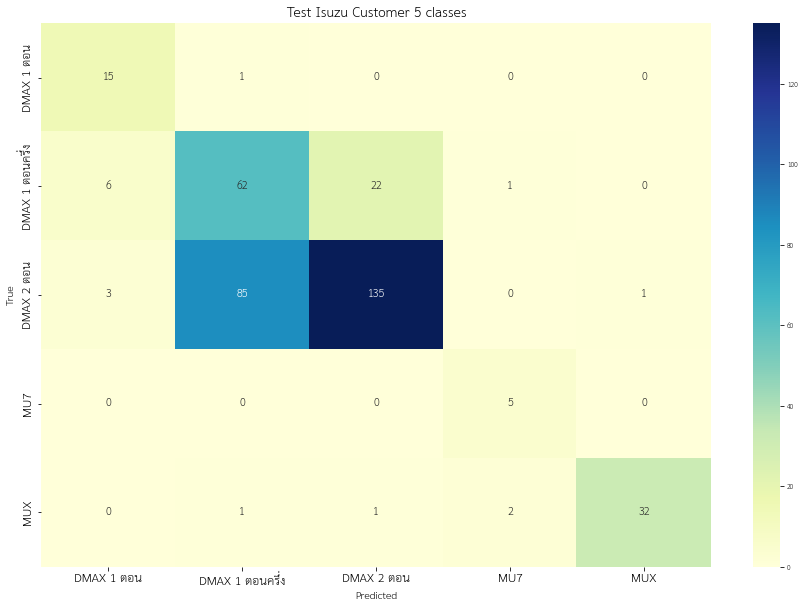

In [ ]:
cf_prediction = list(filter(lambda p: p != "not detect", f_prediction))
print(classification_report(y_true, cf_prediction))
cf_matrix1 = confusion_matrix(y_true, cf_prediction)
plot_cm(cf_matrix1)
plt.title("Test Isuzu Customer 5 classes", fontsize =20)

In [ ]:
import pandas as pd
data = {"img_name": f_name, "predict_number":f_number, "predict_name": f_prediction, "conf": f_score,"result":com}
df = pd.DataFrame(data)
df.sort_values(by=['img_name']).reset_index(drop=True)

,img_name,predict_number,predict_name,conf,result
0,TEST_ISUZU_DMAX 1 ตอน_1.jpg,1,DMAX 1 ตอน,0.999798,YES
1,TEST_ISUZU_DMAX 1 ตอน_10.jpg,1,DMAX 1 ตอน,0.97921,YES
2,TEST_ISUZU_DMAX 1 ตอน_11.jpg,1,DMAX 1 ตอน,0.986773,YES
3,TEST_ISUZU_DMAX 1 ตอน_12.jpg,1,DMAX 1 ตอน,0.999902,YES
4,TEST_ISUZU_DMAX 1 ตอน_13.jpg,1,DMAX 1 ตอน,0.9936,YES
...,...,...,...,...,...
368,TEST_ISUZU_MUX_5.jpg,5,MUX,0.984655,YES
369,TEST_ISUZU_MUX_6.jpg,5,MUX,0.999916,YES
370,TEST_ISUZU_MUX_7.jpg,5,MUX,0.971269,YES
371,TEST_ISUZU_MUX_8.jpg,5,MUX,0.829499,YES


In [ ]:
df.to_csv('/content/isuzu customer 373 5 classes.csv', index=False)

In [ ]:
print("%.2f" %(corr/total*100))

66.76


In [ ]:
#เก็บรูปทายผิดใส่ list
img_custom_list = list(df.loc[df['result'] == 'NO']['img_name'])
pred_custom_list = list(df.loc[df['result'] == 'NO']['predict_name'])
# x = zip(img_custom_list, pred_custom_list)
len(img_custom_list)

124

In [ ]:
#copy รูปที่ predict ผิดไปไว้อีกโฟลเดอร์
import shutil
src_path = '/content/drive/MyDrive/savefig_isuzu/test_isuzu_angle_customer/ไม่รวบ'
inspect_path = os.path.join(src_path, "false")
isExist = os.path.exists(inspect_path)
if not isExist:
    os.makedirs(inspect_path)
    print("{} has been created.".format(inspect_path))
    
for i, f in enumerate(img_custom_list, 1):
  shutil.copy(os.path.join(src_path, f), os.path.join(src_path, 'false'))
  print('{} / {} Copied {}'.format(i, len(img_custom_list), f))

1 / 124 Copied TEST_ISUZU_DMAX 1 ตอน_17.jpg
2 / 124 Copied TEST_ISUZU_DMAX 1 ตอน_7.jpg
3 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_11.jpg
4 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_12.jpg
5 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_16.jpg
6 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_18.jpg
7 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_26.jpg
8 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_28.jpg
9 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_33.jpg
10 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_35.jpg
11 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_36.jpg
12 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_39.jpg
13 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_43.jpg
14 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_44.jpg
15 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_47.jpg
16 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_55.jpg
17 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_59.jpg
18 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_62.jpg
19 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_63.jpg
20 / 124 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_65.jpg
21 / 124 Copied TEST

In [ ]:
%%time
IMAGE_DIR = "/content/drive/MyDrive/test_isuzu_angle_customer"
test_im = sorted(fnmatch.filter(os.listdir(IMAGE_DIR), '*.jpg'))
y_true = []
f_name = []
f_number = []
f_prediction = []
com = []
f_score = []
corr = 0
total = 0
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
for i, im in enumerate(test_im, 1):
  image = skimage.io.imread(os.path.join(IMAGE_DIR, im))
  print("File    {}\nImg# {} / {}".format(im, i, len(test_im)))

  # Run detection
  results = model.detect([image], verbose=0)

  # Visualize results
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_class_names, r['scores'], title=im, save_path = '/content/drive/MyDrive/savefig_isuzu/test_isuzu_angle_customer/รวบ')
  f_name.append(im) #append filename

  try:
    img_class = im.split("_")[2] #get real class name from filename.
    pred = dataset_class_names[r['class_ids'][0]]
    pred_conf = r['scores'][0]

    #รวบรถกระบะ
    truck = {'DMAX 1 ตอน':'DMAX',
                 'DMAX 1 ตอนครึ่ง':'DMAX',
                 'DMAX 2 ตอน':'DMAX'}
    if img_class in truck.keys():
      img_class = truck[img_class]
    if pred in truck.keys():
      pred = truck[pred]

    f_number.append(r['class_ids'][0])
    f_prediction.append(pred) #append prediction
    f_score.append(pred_conf)
    y_true.append(img_class)

    print("Class  {}\nPred   {}\nConf   {}".format(img_class, pred, pred_conf))
    if(img_class == pred):
      corr += 1
      com.append("YES")
    else:
      com.append("NO")

  except IndexError as e:
    f_number.append("not detect")
    f_prediction.append("not detect") 
    com.append("NO")
    f_score.append("not detect")
  
  total += 1
  print('-' * 50)

File    TEST_ISUZU_DMAX 1 ตอน_1.jpg
Img# 1 / 373
Class  DMAX
Pred   DMAX
Conf   0.9997981190681458
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_10.jpg
Img# 2 / 373
Class  DMAX
Pred   DMAX
Conf   0.9792098999023438
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_11.jpg
Img# 3 / 373
Class  DMAX
Pred   DMAX
Conf   0.9867729544639587
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_12.jpg
Img# 4 / 373
Class  DMAX
Pred   DMAX
Conf   0.9999023675918579
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_13.jpg
Img# 5 / 373
Class  DMAX
Pred   DMAX
Conf   0.9935998916625977
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_14.jpg
Img# 6 / 373
Class  DMAX
Pred   DMAX
Conf   0.9984130859375
--------------------------------------------------
File    TEST_ISUZU_DMAX 1 ตอน_15.jpg
Img# 7 / 373
Class  DMAX
Pred   DMAX
Conf   0.999107420444488

              precision    recall  f1-score   support

        DMAX       0.99      0.99      0.99       331
         MU7       0.62      1.00      0.77         5
         MUX       0.97      0.89      0.93        36

    accuracy                           0.98       372
   macro avg       0.86      0.96      0.90       372
weighted avg       0.99      0.98      0.98       372



Text(0.5, 1.0, 'Test Isuzu Customer 3 Classes')

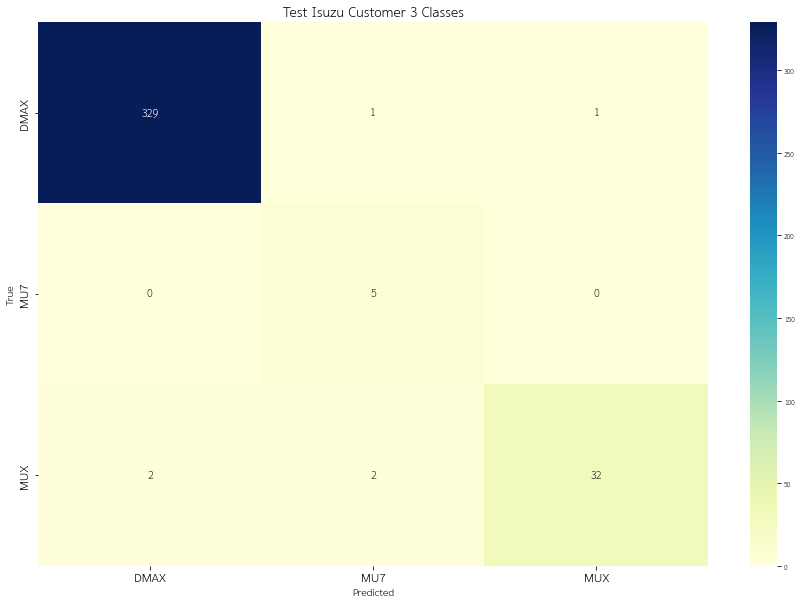

In [ ]:
cf_prediction2 = list(filter(lambda p: p != "not detect", f_prediction))
print(classification_report(y_true, cf_prediction2))
cf_matrix2 = confusion_matrix(y_true, cf_prediction2)
plot_cm(cf_matrix2)
plt.title("Test Isuzu Customer 3 Classes", fontsize =20)

In [ ]:
import pandas as pd
data = {"img_name": f_name, "predict_number":f_number, "predict_name": f_prediction, "conf": f_score,"result":com}
df2 = pd.DataFrame(data)
df2.sort_values(by=['img_name']).reset_index(drop=True)

,img_name,predict_number,predict_name,conf,result
0,TEST_ISUZU_DMAX 1 ตอน_1.jpg,1,DMAX,0.999798,YES
1,TEST_ISUZU_DMAX 1 ตอน_10.jpg,1,DMAX,0.97921,YES
2,TEST_ISUZU_DMAX 1 ตอน_11.jpg,1,DMAX,0.986773,YES
3,TEST_ISUZU_DMAX 1 ตอน_12.jpg,1,DMAX,0.999902,YES
4,TEST_ISUZU_DMAX 1 ตอน_13.jpg,1,DMAX,0.9936,YES
...,...,...,...,...,...
368,TEST_ISUZU_MUX_5.jpg,5,MUX,0.984655,YES
369,TEST_ISUZU_MUX_6.jpg,5,MUX,0.999916,YES
370,TEST_ISUZU_MUX_7.jpg,5,MUX,0.971269,YES
371,TEST_ISUZU_MUX_8.jpg,5,MUX,0.829499,YES


In [ ]:
df2.to_csv('/content/isuzu customer 373 3 classes.csv', index=False, encoding='utf-8')

In [ ]:
print("%.2f" %(corr/total*100))

98.12


In [ ]:
#เก็บรูปทายผิดใส่ list
img_custom_list = list(df.loc[df2['result'] == 'NO']['img_name'])
pred_custom_list = list(df.loc[df2['result'] == 'NO']['predict_name'])
# x = zip(img_custom_list, pred_custom_list)
len(img_custom_list)

7

In [ ]:
#copy รูปที่ predict ผิดไปไว้อีกโฟลเดอร์
import shutil
src_path = '/content/drive/MyDrive/savefig_isuzu/test_isuzu_angle_customer/รวบ'
inspect_path = os.path.join(src_path, "false")
isExist = os.path.exists(inspect_path)
if not isExist:
    os.makedirs(inspect_path)
    print("{} has been created.".format(inspect_path))
    
for i, f in enumerate(img_custom_list, 1):
  shutil.copy(os.path.join(src_path, f), os.path.join(src_path, 'false'))
  print('{} / {} Copied {}'.format(i, len(img_custom_list), f))

1 / 7 Copied TEST_ISUZU_DMAX 1 ตอน_17.jpg
2 / 7 Copied TEST_ISUZU_DMAX 1 ตอนครึ่ง_35.jpg
3 / 7 Copied TEST_ISUZU_DMAX 2 ตอน_219.jpg
4 / 7 Copied TEST_ISUZU_MUX_18.jpg
5 / 7 Copied TEST_ISUZU_MUX_19.jpg
6 / 7 Copied TEST_ISUZU_MUX_2.jpg
7 / 7 Copied TEST_ISUZU_MUX_3.jpg
